In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import tqdm as tqdm
import torch.nn.functional as F
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torchvision import transforms


Functions:


In [ ]:
#transforms.py
def get_transforms(img_size=(50,50)):
    """
    Create data augmentation pipelines for training and validation datasets.
    """
    train_transform = A.Compose([
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2(),
    ])

    val_transform = A.Compose([
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2(),
    ])

    return train_transform, val_transform

# dataloaders.py
class create_dataset(Dataset):
    """
    Custom dataset class for creating a PyTorch dataset from a DataFrame.
    """
    def __init__(self, items, trans=None, labelled=True):
        self.items = items
        self.trans = trans
        self.labelled = labelled
    
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, i):
        item = self.items[i]

        if self.labelled:
            file_path = item['file_path']
            label = item['label']
        else:
            file_path = item
            label = None

        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.trans:
            img = self.trans(image=img)['image']

        if label is None:
            return img
        else:
            return img, torch.tensor(label, dtype=torch.float32)

    
def create_data_loaders(df, batch_size=32, img_size=(50,50), val_split=0.2, labelled=True):
    train_transform, val_transform = get_transforms(img_size)

    if labelled:
        train_ds, val_ds = train_test_split(df, test_size=val_split, random_state=17, shuffle=True)  
        train_dict = train_ds.to_dict(orient='records')
        val_dict = val_ds.to_dict(orient='records')


        train_dataset = create_dataset(train_dict, trans=train_transform)
        val_dataset = create_dataset(val_dict, trans=val_transform)

        train_load = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
        val_load = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

        return train_load, val_load
    else:
        test_dataset = create_dataset(df, trans=val_transform)
        test_load = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

        return test_load
    
#model.py
class CNNmodel(nn.Module):
    def __init__(self, conv_filters=(32, 64, 128), input_channels=3, dense_units=256):
        super(CNNmodel, self).__init__()

        self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_channels, out_channels=conv_filters[0], kernel_size=3, stride=1, padding=1), #convolutional layer 1
        nn.BatchNorm2d(conv_filters[0]), #normalization layer 1
        nn.ReLU(), #activation function
        nn.MaxPool2d(kernel_size=2) #pooling layer
        )

        self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=conv_filters[0], out_channels=conv_filters[1], kernel_size=3, stride=1, padding=1), #convolutional layer 2
        nn.BatchNorm2d(conv_filters[1]), #normalization layer
        nn.ReLU(), #activation function
        nn.MaxPool2d(kernel_size=2) #pooling layer
        )

        self.conv_block3 = nn.Sequential(
        nn.Conv2d(in_channels=conv_filters[1], out_channels=conv_filters[2], kernel_size=3, stride=1, padding=1), #convolutional layer 3
        nn.BatchNorm2d(conv_filters[2]), #normalization layer
        nn.ReLU(), #activation function
        nn.MaxPool2d(kernel_size=2) #pooling layer
        )

        self.fc1 = nn.Linear(conv_filters[2] * 6 * 6, dense_units) #fully connected layer (* 6 * 6 depends on input image size basically is img_size//(2^number of pooling layers))
        self.fc2 = nn.Linear(dense_units, 1) #output layer

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)

        return logits
    
#train.py
def train_model(train_loader, val_loader, epochs=10, lr=0.001, device="cuda", checkpoint_path="E:/Coding_stuffs/Python/notebooks/Medical_image_classification/models/model.pth"):
    #setup
    device = device
    model = CNNmodel().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')

    #train
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, train_total, = 0.0, 0, 0

        for imgs, labels in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            imgs, labels = imgs.to(device), labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / train_total
    
    #validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                imgs, labels = imgs.to(device), labels.to(device).unsqueeze(1)
                outputs = model(imgs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
            
        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total

        print(f"\nEpoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {avg_train_loss:.4f}, Acc: {train_accuracy:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), checkpoint_path)
            print(f"✅ Saved new best model with val loss: {best_val_loss:.4f}")

    print("Training complete!")

    return model

Linking images to labels

In [24]:
labels = pd.read_csv("../data/raw/histopathologic-cancer-detection/train_labels.csv")
labels['file_path'] = "../data/processed/medical_images_resized/" + labels['id'] + ".png"
pd.set_option('display.max_colwidth', None)
labels.head()


,id,label,file_path
0,f38a6374c348f90b587e046aac6079959adf3835,0,../data/processed/medical_images_resized/f38a6374c348f90b587e046aac6079959adf3835.png
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,../data/processed/medical_images_resized/c18f2d887b7ae4f6742ee445113fa1aef383ed77.png
2,755db6279dae599ebb4d39a9123cce439965282d,0,../data/processed/medical_images_resized/755db6279dae599ebb4d39a9123cce439965282d.png
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,../data/processed/medical_images_resized/bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.png
4,068aba587a4950175d04c680d38943fd488d6a9d,0,../data/processed/medical_images_resized/068aba587a4950175d04c680d38943fd488d6a9d.png


Checking create_data_loaders works and images are read properly

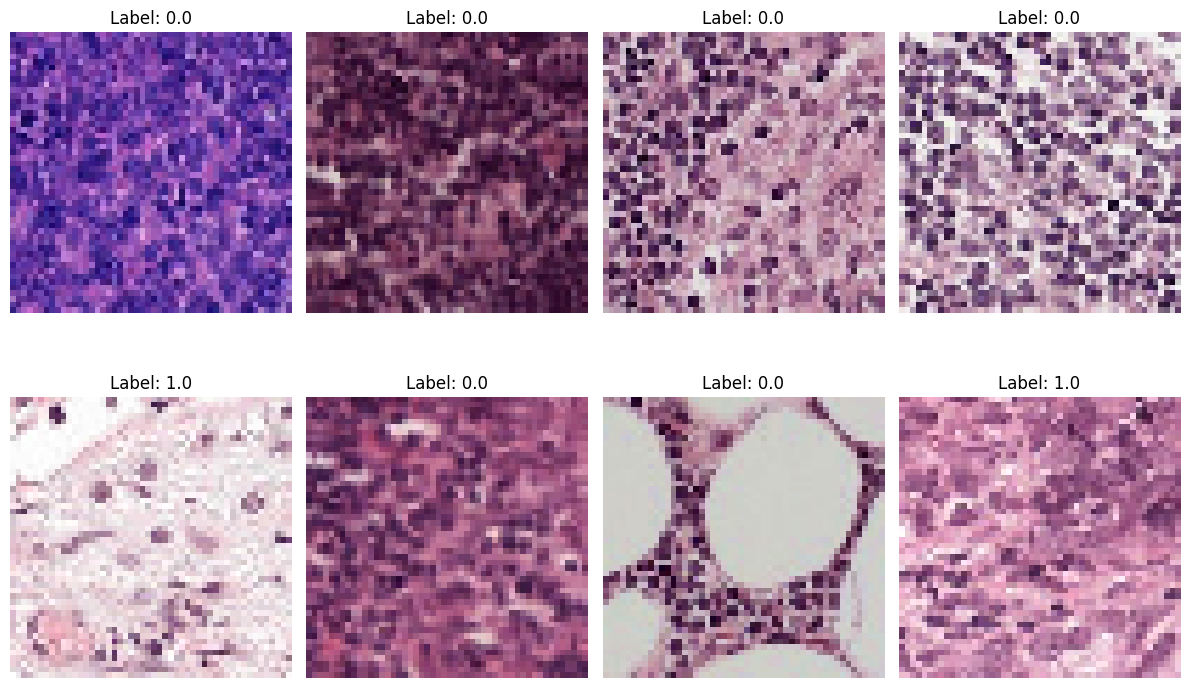

In [ ]:
"""
train_loader, val_loader = create_data_loaders(labels, batch_size=16)
imgs, labels = next(iter(train_loader))
imgs = imgs.permute(0, 2, 3, 1).numpy()
plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow((imgs[i] * 0.5 + 0.5))
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()
"""


Save resized images localy to reduce processing time during training

In [ ]:
"""labels = pd.read_csv("../data/raw/histopathologic-cancer-detection/train_labels.csv")
labels['file_path'] = "../data/raw/histopathologic-cancer-detection/train/" + labels['id'] + ".tif"

resized_file_paths = []

for idx, row in tqdm.tqdm(labels.iterrows(), total=len(labels)):
    orig_path = row['file_path']
    img = cv2.imread(orig_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (50,50))

    # Save to preprocessed folder
    new_name = f"{row['id']}.png"
    save_path = os.path.join("E:/Coding_stuffs/Python/medical_images_checkpoint", new_name)
    cv2.imwrite(save_path, cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))

    resized_file_paths.append(save_path)"""

100%|██████████| 220025/220025 [29:22<00:00, 124.86it/s]


Creating test dataloader, creating training and validation data loaders.

In [ ]:
test_images = "../data/raw/histopathologic-cancer-detection/test/"
test_files = pd.DataFrame({'file_path': [test_images + f for f in os.listdir(test_images)]})

test_loader = create_data_loaders(test_files, batch_size=1024, labelled=False)
train_loader, val_loader = create_data_loaders(labels, batch_size=1024)

train_model(train_loader, val_loader, epochs=10, lr=0.001, device="cuda")

Epoch 1/10 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

In [27]:
print(torch.cuda.is_available())  # True if GPU is available
print(torch.cuda.device_count())  # Number of GPUs detected
print(torch.cuda.get_device_name(0))  # Name of the first GPU
x = torch.randn(2, 3)
print(x.device)  # Should print 'cpu'

x = x.to('cuda')
print(x.device)  # Should print 'cuda:0'
model = CNNmodel()
print(next(model.parameters()).device)  # Should print 'cpu'

model = model.to('cuda')
print(next(model.parameters()).device)

for path in labels['file_path'][:10]:
    print(path, os.path.exists(path))

True
1
NVIDIA GeForce RTX 5060 Ti
cpu
cuda:0
cpu
cuda:0
../data/processed/medical_images_resized/f38a6374c348f90b587e046aac6079959adf3835.png True
../data/processed/medical_images_resized/c18f2d887b7ae4f6742ee445113fa1aef383ed77.png True
../data/processed/medical_images_resized/755db6279dae599ebb4d39a9123cce439965282d.png True
../data/processed/medical_images_resized/bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.png True
../data/processed/medical_images_resized/068aba587a4950175d04c680d38943fd488d6a9d.png True
../data/processed/medical_images_resized/acfe80838488fae3c89bd21ade75be5c34e66be7.png True
../data/processed/medical_images_resized/a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da.png True
../data/processed/medical_images_resized/7f6ccae485af121e0b6ee733022e226ee6b0c65f.png True
../data/processed/medical_images_resized/559e55a64c9ba828f700e948f6886f4cea919261.png True
../data/processed/medical_images_resized/8eaaa7a400aa79d36c2440a4aa101cc14256cda4.png True
